# Ebizzy benchmark eredményeinek elemzése

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
testLocations = [
    "./parametertestResults/ebizzy.json"
]
testNameList = [
    "ebizzy"
]

In [4]:
def avgLst(lst):
    if(isinstance(lst,list)):
        return sum(lst)/len(lst)
    else:
        return lst

def getIntervals(data):
    intervalTop,intervalBottom = 0.0,float(avgLst(data["measurements"][0]["results"]))
    for j in data["measurements"]:
        if(float(avgLst(j["results"])) > intervalTop):
            intervalTop = float(avgLst(j["results"]))
        if(float(avgLst(j["results"])) < intervalBottom):
            intervalBottom = float(avgLst(j["results"]))
    minMaxLst = [intervalBottom,intervalTop]
    return minMaxLst

def featureScale(value,intervalMax,intervalMin):
    return (value-intervalMin)/(intervalMax-intervalMin)


In [5]:
classResultIntervals = [0.20,0.4,0.6,0.8]
classIntervalMinMax = []
dataStrLst = []
for i in range(len(testLocations)):
    file = open(testLocations[i])
    data = json.load(file)
    dataStrLst.append(json.dumps(data))
    minMax = getIntervals(data)
    classIntervalMinMax.append(minMax)

### Adatok beolvasása, Dataframe elkészítése

In [6]:
dataSet = []
for i in range(len(dataStrLst)):
    data_json = json.loads(dataStrLst[i])
    classResult = 0
    for j in data_json["measurements"]:
        swap = 1 if ( int(j["parameters"]["vm.swap"]) > 0 ) else 0                                     
        testType = data_json["testType"]
        testName = data_json["testName"]
        batchProcess = 1 if ( int(j["parameters"]["prio"]) > 0 ) else 0
        serverWorkload = 1 if( int(j["parameters"]["min_gran"]) > 1500000) else 0
        resultNormalized = featureScale(float(avgLst(j["results"])),classIntervalMinMax[i][1],classIntervalMinMax[i][0])
        for k in range(len(classResultIntervals)):
            if(resultNormalized > classResultIntervals[k]):
                classResult = (k+1)
        dataSet.append([testType,testName,batchProcess,classResult,serverWorkload,swap,resultNormalized,int(j["parameters"]["latency"]),int(j["parameters"]["min_gran"]),int(j["parameters"]["wakeup_gran"]),int(j["parameters"]["prio"]),int(j["parameters"]["vm.swap"])],)
df = pd.DataFrame(dataSet,columns=["testType","testName","batchProcess","resultClass","serverWorkload","swap","results","latency","min_gran","wakeup_gran","priority","vm.swappiness"])

In [7]:
df

,testType,testName,batchProcess,resultClass,serverWorkload,swap,results,latency,min_gran,wakeup_gran,priority,vm.swappiness
0,cpu,ebizzy,0,4,0,0,0.809478,100000,100000,0,-20,0
1,cpu,ebizzy,0,4,0,1,0.829435,100000,100000,0,-20,33
2,cpu,ebizzy,0,4,0,1,0.825037,100000,100000,0,-20,66
3,cpu,ebizzy,0,3,0,1,0.795037,100000,100000,0,-20,100
4,cpu,ebizzy,0,4,0,0,0.838969,100000,100000,0,-6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,cpu,ebizzy,1,3,1,1,0.767555,1000000000,1000000000,1000000000,6,100
1020,cpu,ebizzy,1,2,1,0,0.471984,1000000000,1000000000,1000000000,19,0
1021,cpu,ebizzy,1,3,1,1,0.703488,1000000000,1000000000,1000000000,19,33
1022,cpu,ebizzy,1,4,1,1,0.899731,1000000000,1000000000,1000000000,19,66


In [8]:
dfLabels = ["latency","min_gran","wakeup_gran","priority","vm.swappiness"]
titles=["Latency_ns","Min_granularity_ns","Wakeup_granularity_ns","Priority","vm.swappiness"]

### Itt láthatók hogy az egyes beállításokkal,  milyen eredmények születtek, azonban a kernel változók egymástól nem függetlenek. 

[Text(0, 0.5, 'Results')]

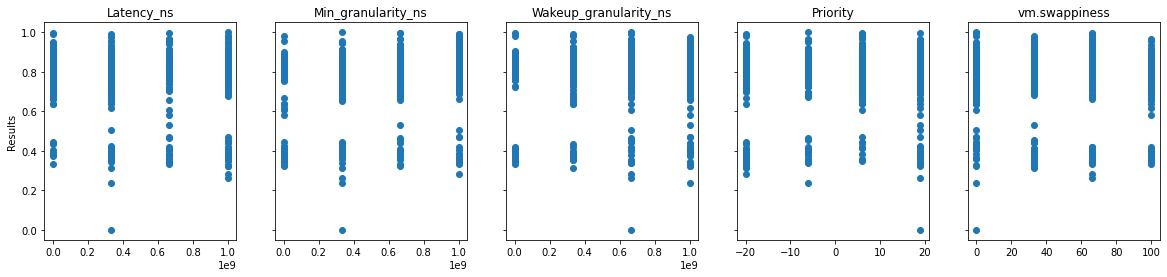

In [9]:
plotY = df["results"].to_numpy()
f, ax = plt.subplots(1,5,sharey=True,figsize=(20,4))

for i in range(5):
    plotX = df[dfLabels[i]].to_numpy()
    ax[i].plot(plotX,plotY,"o")
    ax[i].set_title(titles[i])
plt.setp(ax[0], ylabel="Results")

### Összesítő torta diagram, amin megfigyelhetjük hogy született eredmények nagyrésze a legjobb kategóriába került. Ebből következtethetünk arra hogy a több cpu terhelő felhasználási módhoz a legtöbb beállítás amit végeztem a kernel változókon, megfelelő teljesítményt eredményez. Az eredmények romlása akkor jelentkezik amikor a sched\_wakeup\_granularity\_ns változóhoz nagyobb értékét állítunk mint a sched\_latency\_ns fele. Ekkor sajnos a kis időciklusú taszkok nem lesznek képesek versenyezni a többi folyamattal amikor a processzort éppen nagy terhelés alatt áll.

4    598
3    354
1     45
2     27
Name: resultClass, dtype: int64

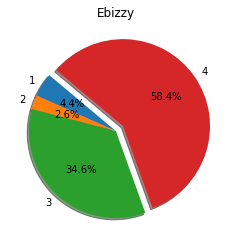

<Figure size 720x360 with 0 Axes>

In [10]:
plotValues=[]
explode = (0, 0, 0, 0.1)  
for i in range(1,5):
    plotValues.append((len(df.loc[ (df["resultClass"]==i), "resultClass"].to_numpy())))    
plt.pie(plotValues,labels=["1","2","3","4"], explode=explode,autopct='%1.1f%%',shadow=True, startangle=140)
plt.title("Ebizzy")
plt.figure(figsize=(10,5))
df["resultClass"].value_counts()